
# Notebook 1: Visualizing Satellite Imagery

In this notebook, you will:
- Load satellite imagery
- Display it on an interactive map
- Understand what satellite data represents

Link to acces Earth Engine Datasets: https://developers.google.com/earth-engine/datasets/catalog

Think of this as Google Maps, but for scientific data.

In [21]:
import ee
import geemap
ee.Authenticate()
ee.Initialize(project='big-data-development')

In [22]:
## Create an interactive map


In [23]:
Map = geemap.Map(center=[20, 0], zoom=2)
Map

Map(center=[20, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(child…


## Select a country boundary (Pakistan example)

All satellite data will be summarized over this boundary.


In [24]:
country = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017") \
    .filter(ee.Filter.eq("country_na", "Pakistan"))

Map.centerObject(country, 5)
Map.addLayer(country, {}, "Pakistan")
Map


Map(center=[29.88406293231847, 69.19999765510337], controls=(WidgetControl(options=['position', 'transparent_b…

## Load Landsat satellite imagery (2019)

In [25]:
landsat = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2") \
    .filterBounds(country) \
    .filterDate("2019-01-01", "2019-12-31")

image = landsat.median()

## Display the satellite image

In [26]:

vis_params = {
    "bands": ["SR_B4", "SR_B3", "SR_B2"],
    "min": 0,
    "max": 30000
}

Map.addLayer(image, vis_params, "Landsat 2019")
Map

Map(center=[29.88406293231847, 69.19999765510337], controls=(WidgetControl(options=['position', 'transparent_b…


# Section 2: Economic Activity Using Night Lights

Night-time lights observed from space are commonly used as a proxy for:
- Economic activity
- Infrastructure
- Urbanization

Brighter areas generally indicate more economic activity.



## Load country boundary

In [27]:
# country = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017") \
#     .filter(ee.Filter.eq("country_na", "Pakistan"))

## Load night lights data

In [28]:

nightlights = ee.ImageCollection("NOAA/VIIRS/DNB/MONTHLY_V1/VCMCFG") \
    .filterBounds(country)


## Select two years for comparison

In [29]:
nl_2015 = nightlights.filterDate("2015-01-01", "2015-12-31").mean().select("avg_rad")
nl_2022 = nightlights.filterDate("2022-01-01", "2022-12-31").mean().select("avg_rad")

## Visualization settings

In [30]:
nl_vis = {
    "min": 0,
    "max": 60,
    "palette": ["black", "blue", "purple", "red", "orange", "yellow"]
}
nl_2015 = (
    nightlights
    .filterDate("2015-01-01", "2015-12-31")
    .mean()
    .select("avg_rad")
    .clip(country)
)

nl_2022 = (
    nightlights
    .filterDate("2022-01-01", "2022-12-31")
    .mean()
    .select("avg_rad")
    .clip(country)
)

## Display night lights maps

In [31]:
Map = geemap.Map(center=[30, 70], zoom=5)
Map.addLayer(
    country,
    {"color": "cyan", "fillColor": "00000000", "width": 2},
    "Pakistan Boundary"
)
Map.addLayer(nl_2015, nl_vis, "Night Lights 2015")
Map.addLayer(nl_2022, nl_vis, "Night Lights 2022")

Map

Map(center=[30, 70], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…


## Function to compute average night light intensity

In [32]:
def avg_nightlights(year):
    img = nightlights \
        .filterDate(f"{year}-01-01", f"{year}-12-31") \
        .mean()

    stats = img.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=country.geometry(),
        scale=1000,
        maxPixels=1e13
    )

    return stats.get("avg_rad")

## Generate time series

In [33]:

years = list(range(2012, 2023))
values = [avg_nightlights(y) for y in years]

nl_series = ee.List(values).getInfo()

##Assumption Testing
“Satellites measure light at night. More light usually means more economic activity. We average all night-time light pixels inside Pakistan for each year. Plotting those averages over time gives us an economic trend.”

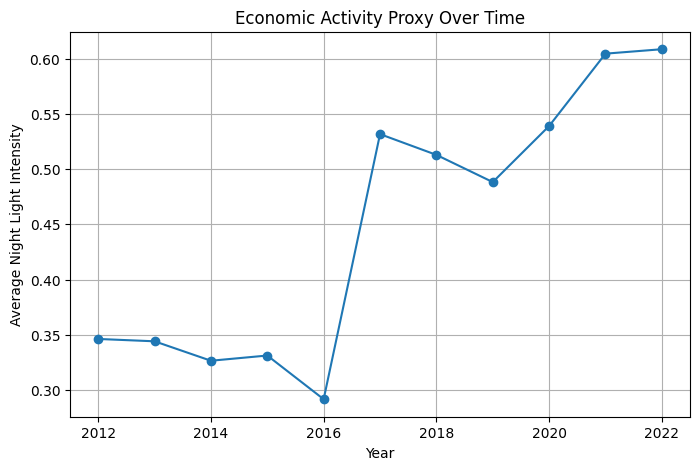

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 5))
plt.plot(years, nl_series, marker="o")
plt.xlabel("Year")
plt.ylabel("Average Night Light Intensity")
plt.title("Economic Activity Proxy Over Time")
plt.grid(True)
plt.show()

## New Type of Analysis

In [35]:
landsat = (
    ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
    .filterBounds(country)
    .filterDate("2022-01-01", "2022-12-31")
)

ndvi = (
    landsat
    .median()
    .normalizedDifference(["SR_B5", "SR_B4"])
    .clip(country)
)


In [36]:
ndvi_vis = {
    "min": -0.1,
    "max": 0.5,
    "palette": ["brown", "yellow", "green"]
}

Map = geemap.Map(center=[30, 70], zoom=5)

Map.addLayer(ndvi, ndvi_vis, "NDVI (Vegetation Health)")
Map.addLayer(
    country,
    {"color": "white", "fillColor": "00000000", "width": 2},
    "Pakistan Boundary"
)

Map

Map(center=[30, 70], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(chil…

In [37]:
dataset = ee.Image('NASA/ASTER_GED/AG100_003');
elevation = dataset.select('elevation').clip(country);
elevationVis = {
  "min": -15.0,
  "max": 5000.0,
  "palette": [
    '0602ff', '235cb1', '307ef3', '269db1', '30c8e2', '32d3ef', '3ae237',
    'b5e22e', 'd6e21f', 'fff705', 'ffd611', 'ffb613', 'ff8b13', 'ff6e08',
    'ff500d', 'ff0000', 'de0101', 'c21301'
  ],
};
Map = geemap.Map()
Map.centerObject(country, 5)

# Add elevation layer
Map.addLayer(elevation, elevationVis, "Elevation (Pakistan only)")

# Add Pakistan boundary
Map.addLayer(
    country,
    {"color": "white", "fillColor": "00000000", "width": 2},
    "Pakistan Boundary"
)

# Display map
Map

Map(center=[29.88406293231847, 69.19999765510337], controls=(WidgetControl(options=['position', 'transparent_b…

In [38]:
elevation_stats = elevation.reduceRegion(
    reducer=ee.Reducer.minMax().combine(
        reducer2=ee.Reducer.mean(),
        sharedInputs=True
    ),
    geometry=country.geometry(),
    scale=1000,
    maxPixels=1e13
)

elevation_stats.getInfo()

{'elevation_max': 7776,
 'elevation_mean': 1027.4583427565374,
 'elevation_min': -16}

In [39]:
lowland = elevation.lt(20)

Map.addLayer(
    lowland.updateMask(lowland),
    {"palette": ["cyan"]},
    "Low-lying Areas (<20m)"
)

In [40]:
low = elevation.lt(200)
mid = elevation.gte(200).And(elevation.lt(1000))
high = elevation.gte(1000)

In [41]:
slope = ee.Terrain.slope(elevation)

slope_vis = {
    "min": 0,
    "max": 30,
    "palette": ["white", "yellow", "orange", "red"]
}

Map.addLayer(slope, slope_vis, "Slope (Terrain Ruggedness)")

In [42]:
dataset_2 = ee.ImageCollection('ECMWF/ERA5/HOURLY').filter(ee.Filter.date('2020-07-01', '2020-07-02'));

In [43]:
visualization = {
  'bands': ['temperature_2m'],
  'min': 250.0,
  'max': 320.0,
  'palette': [
    '000080', '0000d9', '4000ff', '8000ff', '0080ff', '00ffff',
    '00ff80', '80ff00', 'daff00', 'ffff00', 'fff500', 'ffda00',
    'ffb000', 'ffa400', 'ff4f00', 'ff2500', 'ff0a00', 'ff00ff',
  ]
};

In [44]:
Map.setCenter(22.2, 21.2, 3);

Map.addLayer(dataset_2, visualization, 'Air temperature [K] at 2m height');
Map

Map(center=[21.2, 22.2], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(…